In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import datetime as dt

## W Trakcie pracy niegotowe jeszcze.

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
sp500 = yf.download('^GSPC', start='2000-01-01', end='2025-01-01')

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [ ]:
close_prices = sp500['Close'].values.reshape(-1, 1)
scaler = MinMaxScaler() # od 0 do 1
close_prices_scaled = scaler.fit_transform(close_prices)

In [ ]:
# Funkcja do tworzenia sekwencji
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, 0])
        y.append(data[i+seq_length, 0])
    return np.array(X), np.array(y)

dni_predycji = 60
X, y = create_sequences(close_prices_scaled, dni_predycji)
# X = X.reshape(-1, 1)
# y = y.reshape(-1, 1)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [ ]:
model = Sequential([
    LSTM(50, input_shape=(60, 1), return_sequences=False),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.2759e-05
Epoch 2/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.2151e-05
Epoch 3/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 1.1573e-05
Epoch 4/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.1689e-05
Epoch 5/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.2081e-05
Epoch 6/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.1173e-05
Epoch 7/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 1.1089e-05
Epoch 8/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.1828e-05
Epoch 9/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1.2645e-05
Epoch 10/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 1.1672e-05
Epoch 11/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 1.0175e-05
Epoch 12/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 1.2367e-05
Epoch 13/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 1.0339e-05
Epoch 14/50
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss

In [ ]:
predictions = model.predict(X_test)

# Odwrócenie skalowania
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [ ]:
# Obliczenie MSE
mse = mean_squared_error(y_test, predictions)
print(f"Błąd średniokwadratowy (MSE): {mse}")

Błąd średniokwadratowy (MSE): 3956.736542801112


## Bardziej zaawansowany model

In [ ]:
#drugi model trochę większy
model1 = Sequential()

model1.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model1.add(Dropout(0.2))
model1.add(LSTM(units=50, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(units=50))
model1.add(Dropout(0.2))
model1.add(Dense(units=1))

model1.compile(optimizer='adam', loss='mse')
model1.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 60, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model1.fit(X_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 19s 121ms/step - loss: 1.5107e-04
Epoch 2/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 14s 82ms/step - loss: 1.4956e-04
Epoch 3/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - loss: 1.2269e-04
Epoch 4/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - loss: 1.2913e-04
Epoch 5/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 79ms/step - loss: 1.2968e-04
Epoch 6/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - loss: 1.2905e-04
Epoch 7/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - loss: 1.3126e-04
Epoch 8/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - loss: 1.3849e-04
Epoch 9/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - loss: 1.2328e-04
Epoch 10/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 80ms/step - loss: 1.4006e-04
Epoch 11/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 13s 80ms/step - loss: 1.2247e-04
Epoch 12/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - loss: 1.4675e-04
Epoch 13/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - loss: 1.3156e-04
Epoch 14/25
156/156 ━━━━━━━━━━━━━━━━━━━━ 20s 8

In [ ]:
predictions = model.predict(X_test)

# Odwrócenie skalowania
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


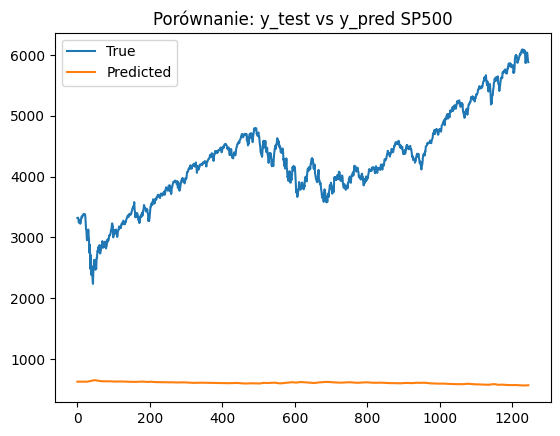

In [ ]:
plt.plot(y_test, label='True')
plt.plot(predictions, label='Predicted')
plt.title("Porównanie: y_test vs y_pred SP500")
plt.legend()
plt.show()

## Porównanie z bardzo prostym modelem

In [ ]:
baseline_predictions = np.full_like(y_test, np.mean(y_train))

# Obliczenie błędu średniokwadratowego (MSE) dla modelu referencyjnego
baseline_mse = mean_squared_error(y_test, baseline_predictions)
print(f"Błąd średniokwadratowy modelu referencyjnego (MSE): {baseline_mse}")

Błąd średniokwadratowy modelu referencyjnego (MSE): 0.2664942277633456


In [ ]:

# # Tworzymy nowy DataFrame do obliczeń średniej kroczącej
# sp5001 = pd.DataFrame()
# split = int(len(y) * 0.8)  # Podział na zbiór treningowy i testowy
# sp5001['Y'] = sp500["Close"][:split]  # Dane treningowe (pierwsze 80%)

# # Obliczanie średniej kroczącej (SMA) z 16 dni
# window_size = 16
# sp5001['SMA'] = sp5001['Y'].rolling(window=window_size).mean()

# # Usuwamy pierwsze 15 NaN wartości
# sp5001 = sp5001.dropna()

# # Konwersja SMA na listę i dostosowanie długości do y_test
# sma_values = sp5001['SMA'].values  # Pobieramy wartości SMA

# # Dopasowanie długości SMA do y_test (odcinamy pierwsze `window_size-1` wartości)
# y_test_adjusted = y_test[window_size-1:]  # Dopasowanie długości

# sma_values = np.full_like(y_test_adjusted, sma_values)
# # Obliczenie MSE dla modelu średniej kroczącej
# baseline_mse = mean_squared_error(y_test_adjusted, sma_values)
# print(f"Błąd średniokwadratowy modelu średniej kroczącej (MSE): {baseline_mse}")




### Zapisywanie, wczytywanie i wyświetlanie wykresów pierwszego Modelu.




In [ ]:
from google.colab import drive
from google.colab import files

# Zapisz model lokalnie w katalogu Colab
model.save('lstm_model.keras')
files.download('lstm_model.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving lstm_model.keras to lstm_model.keras


In [ ]:
# Wczytanie modelu z Google Drive
from tensorflow.keras.models import load_model
model = load_model("lstm_model.keras")

# Sprawdzenie struktury modelu
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,355 (122.48 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 20,904 (81.66 KB)

In [ ]:
history.history.keys()

dict_keys(['loss'])

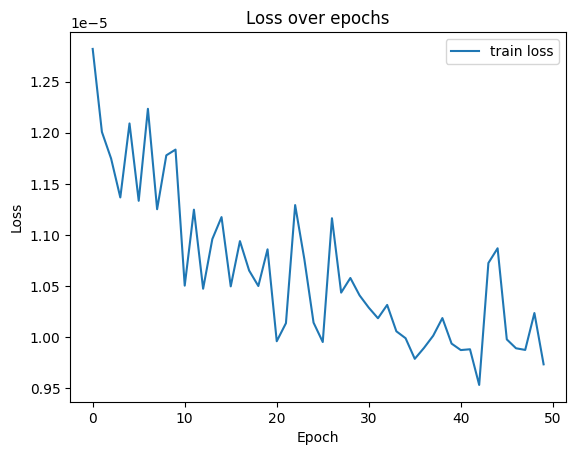

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

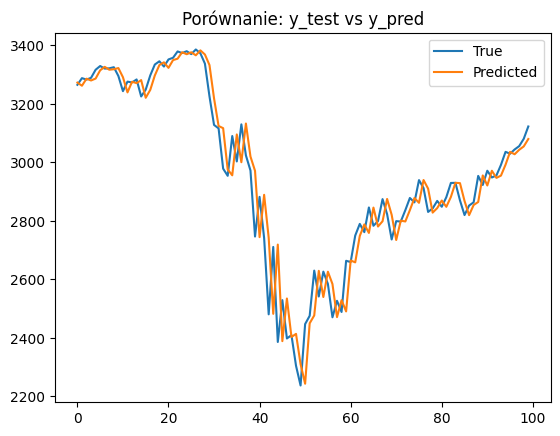

In [ ]:
plt.plot(y_test[:100], label='True')
plt.plot(predictions[:100], label='Predicted')
plt.title("Porównanie: y_test vs y_pred")
plt.legend()
plt.show()